Neuroon cross-validation
------------------------


Neuroon and PSG recordings were simultanously collected over the course of two nights. This analysis will show whether Neuroon is able to accurately classify sleep stages. The PSG classification will be a benchmark against which Neuroon performance will be tested. "The AASM Manual for te Scoring of Sleep ad Associated Events" identifies 5 sleep stages: 

* Stage W (Wakefulness)
* Stage N1 (NREM 1)
* Stage N1 (NREM 2)
* Stage N1 (NREM 3)
* Stage R (REM)
<img src="images/sleep_stages.png">


These stages can be identified following the rules guidelines in [1] either visually or digitally using combined information from EEG, EOG and EMG. Extensive research is beeing conducted on developing automated and simpler methods for sleep stage classification suitable for everyday home use (for a review see [2]). Automatic methods based on single channel EEG, which is the Neuroon category, were shown to work accurately when compared to PSG scoring [3].  

[1] Berry RB BR, Gamaldo CE, Harding SM, Lloyd RM, Marcus CL, Vaughn BV; for the American Academy of Sleep Medicine. The AASM Manual for the Scoring of Sleep and Associated Events: Rules, Terminology and Technical Specifications.,Version 2.0.3. Darien, IL: American Academy of Sleep Medicine; 2014.

[2] Van De Water, A. T. M., Holmes, A., & Hurley, D. a. (2011). Objective measurements of sleep for non-laboratory settings as alternatives to polysomnography - a systematic review. Journal of Sleep Research, 20, 183–200. 

[3] Berthomier, C., Drouot, X., Herman-Stoïca, M., Berthomier, P., Prado, J., Bokar-Thire, D. d’Ortho, M.P. (2007). Automatic analysis of single-channel sleep EEG: validation in healthy individuals. Sleep, 30(11), 1587–1595.


Signals time-synchronization using crosscorelation
--------------------------------------------------

Neuroon and PSG were recorded on devices with (probably) unsycnhronized clocks. First we will use a cross-correlation method [4] to find the time offset between the two recordings.

[4] Fridman, L., Brown, D. E., Angell, W., Abdić, I., Reimer, B., & Noh, H. Y. (2016). Automated synchronization of driving data using vibration and steering events. Pattern Recognition Letters, 75, 9-15.

Define cross correlation function - code from: (http://lexfridman.com/blogs/research/2015/09/18/fast-cross-correlation-and-time-series-synchronization-in-python/)

for other examlpes see: (http://stackoverflow.com/questions/4688715/find-time-shift-between-two-similar-waveforms)



In [2]:
# Imports and setup 

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict 
from datetime import timedelta
from itertools import tee

plt.rcParams['figure.figsize'] = (9.0, 5.0)





/Users/user/.virtualenvs/notebook/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from parse_signal import load_psg, load_neuroon

# Cross-correlation function. Equivalent to numpy.correlate(x,y mode = 'full') but faster for large arrays 
# This function was tested against other cross correlation methods in -- LINK TO OTHER NOTEBOOK
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift < 0 means that y starts 'shift' time steps before x # shift > 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift,c


def cross_correlate():
    # Load the signal from hdf database and parse it to pandas series with datetime index
    psg_signal =  load_psg('F3-A2')
    neuroon_signal =  load_neuroon()
    # Resample the signal to 100hz, to have the same length for cross correlation
    psg_10 = psg_signal.resample('10ms').mean()
    neuroon_10 = neuroon_signal.resample('10ms').mean()
    
    # Create ten minute intervals
    dates_range = pd.date_range(psg_signal.head(1).index.get_values()[0], neuroon_signal.tail(1).index.get_values()[0], freq="10min")
    
    # Convert datetime interval boundaries to string with only hours, minutes and seconds
    dates_range = [d.strftime('%H:%M:%S') for d in dates_range]
    
    
    all_coefs = []
    
    #  iterate over overlapping pairs of 10 minutes boundaries and cut epochs from the signal
    for start, end in pairwise(dates_range):
        # cut 10 minute epochs from the signal
        neuroon_cut = neuroon_10.between_time(start, end)
        psg_cut = psg_10.between_time(start, end)
        
        # Compute the correlation using fft convolution
        shift, coeffs = compute_shift(neuroon_cut, psg_cut)
        #normalize the coefficients because they will be shown on the same heatmap and need a common color scale
        all_coefs.append((coeffs - coeffs.mean()) / coeffs.std())
        
        print('max corr at shift %s is at sample %i with raw value %i'%(start, shift, max(coeffs)))

    all_coefs = np.array(all_coefs)
    return all_coefs, dates_range

# This function is used to iterate over a list, taking two consecutive items at each iteration
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

loading


In [40]:
# Construct a matrix where each row represents a 10 minute window from the recording
# and each column represent correlation coefficient between neuroon and psg signals offset by samples number.
# 0 samples offset coefficient is stored at the middle column -1. Negative offset and positive offset span left and right from the center.
# offset < 0 means that psg starts 'shift' time steps before neuroon
# offset > 0 means that psg starts 'shift' time steps after neuroon

coeffs_matrix, dates = cross_correlate()

max corr at shift 22:29:48 is at sample -8404 with raw value 1794924
max corr at shift 22:39:48 is at sample -23198 with raw value 204914
max corr at shift 22:49:48 is at sample -16044 with raw value 60936
max corr at shift 22:59:48 is at sample -17393 with raw value 75195
max corr at shift 23:09:48 is at sample -16027 with raw value 832015
max corr at shift 23:19:48 is at sample -19625 with raw value 347326
max corr at shift 23:29:48 is at sample -16046 with raw value 160085
max corr at shift 23:39:48 is at sample -16046 with raw value 148816
max corr at shift 23:49:48 is at sample -16047 with raw value 314764
max corr at shift 23:59:48 is at sample 6303 with raw value 224245
max corr at shift 00:09:48 is at sample 25882 with raw value 421724
max corr at shift 00:19:48 is at sample -16048 with raw value 147590
max corr at shift 00:29:48 is at sample -16047 with raw value 319385
max corr at shift 00:39:48 is at sample -16045 with raw value 623775
max corr at shift 00:49:48 is at sample

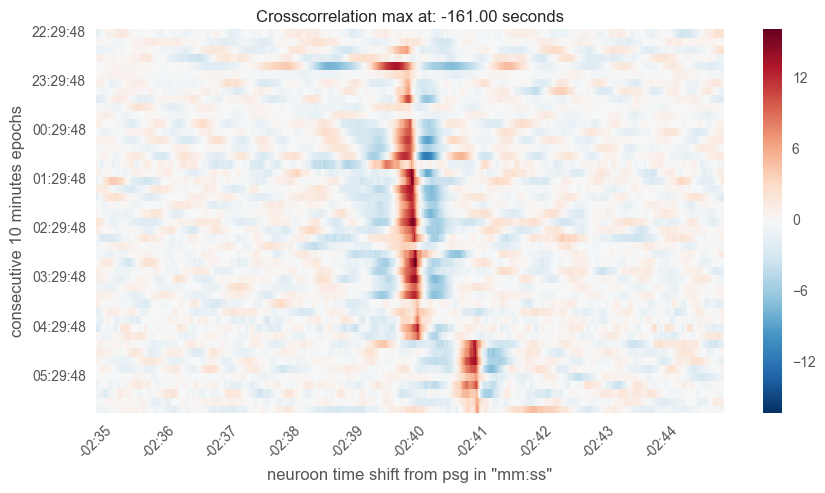

In [35]:
from plotting_collection import plot_crosscorrelation_heatmap

#Plot part of the coefficients matrix centered around the max average correlation for all 10 minute windows
plot_crosscorrelation_heatmap(coeffs_matrix, dates, window = 500)

* From the crosscorrelation matrix of the eeg signals we can see the two devices are off by 2 minutes 40 seconds. 
* At 04:49:48 an additional 1 second lag appeared. 
* The lag is not constant, however it increases barely noticeabely by less than a 100ms from the first to the fifth hour of the recording.

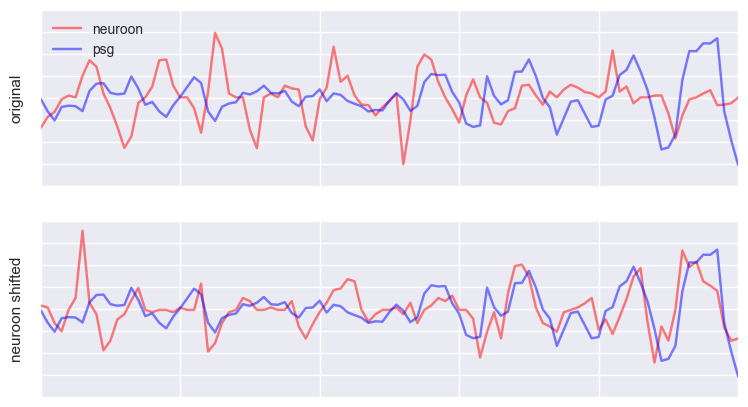

In [53]:
# Now lets try plotting the signals with and without the time shift to see if the shift can be seen
# No need to resample now, plotting against the datetime index will align the signals
psg_signal = load_psg('F3-A2')
neuroon_signal = load_neuroon()

# Get the time where we know the correlation was strong
start = '03:52:10'
end = '03:52:20'

# Downsample the signal so bigger window can be shown on the plot while still readable
neuroon_cut = neuroon_signal.between_time(start, end).resample('100ms').mean().as_matrix()
psg_cut = psg_signal.between_time(start, end).resample('100ms').mean().as_matrix()

# Normalize the signal to plot it on the same scale
neuroon_cut = (neuroon_cut - neuroon_cut.mean()) / neuroon_cut.std()
psg_cut = (psg_cut - psg_cut.mean()) / psg_cut.std()

fig, axes = plt.subplots(2)
# Plot the original signal
axes[0].plot(neuroon_cut, color = 'r', alpha = 0.5, label = 'neuroon')
axes[0].plot(psg_cut, color = 'b', alpha = 0.5, label = 'psg')
axes[0].legend(loc = 'upper left')
axes[0].set_ylabel('original')


# Shift the signal by number of samples identified in cross correlation. Use the same shift freq as in crosscorrelation
neuroon_cut2 = neuroon_signal.shift(-16056, freq = '10ms').between_time(start, end).resample('100ms').mean().as_matrix()
psg_cut2 = psg_signal.between_time(start, end).resample('100ms').mean().as_matrix()
# Normalize
neuroon_cut2 = (neuroon_cut2 - neuroon_cut2.mean()) / neuroon_cut2.std()
psg_cut2 = (psg_cut2 - psg_cut2.mean()) / psg_cut2.std()

#Plot the time shifted signal
axes[1].plot(neuroon_cut2, color = 'r', alpha = 0.5)
axes[1].plot(psg_cut2, color = 'b', alpha = 0.5)
axes[1].set_ylabel('neuroon shifted')

for ax in axes:
    ax.set_ylim(-4,4)
    ax.set_xticklabels([])   
    ax.set_yticklabels([])    



Hipnogram time-delay
--------------------
From the crosscorrelation of the eeg signals we can see the two devices are off by 2 minutes 41 seconds. Now we'll see if there is a point in time where the hipnograms are most simmilar. The measure of hipnogram simmilarity will be the sum of times when two devices classified the same sleep stage.


In [37]:
import parse_hipnogram as ph

def get_hipnogram_intersection(neuroon_hipnogram, psg_hipnogram, time_shift):

    neuroon_hipnogram.index = neuroon_hipnogram.index + timedelta(seconds = int(time_shift))

    
    combined = psg_hipnogram.join(neuroon_hipnogram, how = 'outer', lsuffix = '_psg', rsuffix = '_neuro')
    
    combined.loc[:, ['stage_num_psg', 'stage_name_psg', 'stage_num_neuro', 'stage_name_neuro', 'event_number_psg', 'event_number_neuro']] = combined.loc[:, ['stage_num_psg', 'stage_name_psg', 'stage_num_neuro', 'stage_name_neuro', 'event_number_psg', 'event_number_neuro']].fillna( method = 'bfill')        
    
    combined.loc[:, ['stage_shift_psg', 'stage_shift_neuro']] = combined.loc[:, ['stage_shift_psg', 'stage_shift_neuro']].fillna( value = 'inside')      
    
    # From the occupied room number subtract the room occupied by another mouse.
    combined['overlap'] = combined['stage_num_psg'] - combined['stage_num_neuro']
    
    same_stage = combined.loc[combined['overlap'] == 0]
    same_stage.loc[:, 'event_union'] = same_stage['event_number_psg'] + same_stage['event_number_neuro']


#    common_window = np.array([neuroon_hipnogram.tail(1).index.get_values()[0] - psg_hipnogram.head(1).index.get_values()[0]],dtype='timedelta64[m]').astype(int)[0]

    all_durations = OrderedDict()

    for stage_name, intersection in same_stage.groupby('event_union'):
            # Subtract the first row timestamp from the last to get the duration. Store as the duration in milliseconds.
            duration = (intersection.index.to_series().iloc[-1]- intersection.index.to_series().iloc[0]).total_seconds()
                                 
            stage_id = intersection.iloc[0, intersection.columns.get_loc('stage_name_neuro')] 
            # Keep appending results to a list stored in a dict. Check if the list exists, if not create it.
            if stage_id not in all_durations.keys():
                all_durations[stage_id] = [duration]
                
            else:   
                all_durations[stage_id].append(duration)
            

    
    means = OrderedDict()
    stds = OrderedDict()
    sums = OrderedDict()
    stages_sum = 0
    #Adding it here so its first in ordered dict and leftmost on the plot
    sums['stages_sum'] = 0
    for key, value in all_durations.items():
        #if key != 'wake':
        means[key] = np.array(value).mean()
        stds[key] = np.array(value).std()
        sums[key] = np.array(value).sum()
        
        stages_sum += np.array(value).sum()   
    
    sums['stages_sum'] = stages_sum
    # Divide total seconds by 60 to get minutes 
    #return stages_sum
    return sums, means, stds

In [38]:
def intersect_with_shift():
    psg_hipnogram = ph.parse_psg_stages()
    neuroon_hipnogram = ph.parse_neuroon_stages()
    
    intersection = OrderedDict([('wake', []), ('rem',[]), ('N1',[]), ('N2',[]), ('N3', []), ('stages_sum', [])])

    shift_range = np.arange(-500, 100, 10)
    for shift in shift_range:
        sums, _, _ = get_hipnogram_intersection(neuroon_hipnogram.copy(), psg_hipnogram.copy(), shift)
        for stage, intersect_dur in sums.items():
            intersection[stage].append(intersect_dur)
    
    return intersection, shift_range


In [50]:

def plot_intersection(intersection, shift_range):
    
    psg_hipnogram = ph.parse_psg_stages()
    neuroon_hipnogram = ph.parse_neuroon_stages()
    
    stage_color_dict = {'N1' : 'royalblue', 'N2' :'forestgreen', 'N3' : 'coral', 'rem' : 'plum', 'wake' : 'lightgrey', 'stages_sum': 'dodgerblue'}

    
    fig, axes = plt.subplots(2)
    zscore_ax = axes[0].twinx()
    
    for stage in ['rem', 'N2', 'N3', 'wake']:
        intersect_sum = np.array(intersection[stage])
        z_scored = (intersect_sum - intersect_sum.mean()) / intersect_sum.std()
        zscore_ax.plot(shift_range, z_scored, color = stage_color_dict[stage], label = stage, alpha = 0.5, linestyle = '--')
        

    max_overlap = shift_range[np.argmax(intersection['stages_sum'])]
    fig.suptitle('max overlap at %i seconds offset'%max_overlap)
    axes[0].plot(shift_range, intersection['stages_sum'], label = 'stages sum', color = 'dodgerblue')
    axes[0].axvline(max_overlap, color='k', linestyle='--')

    axes[0].set_ylabel('time in the same sleep stage')
    axes[0].set_xlabel('offset in seconds')
    
    axes[0].legend(loc = 'center right')
    zscore_ax.grid(b=False)
    zscore_ax.legend()
        
    sums0, means0, stds0  = get_hipnogram_intersection(neuroon_hipnogram.copy(), psg_hipnogram.copy(), 0)
#
    width = 0.35 
    ind = np.arange(5)
    colors_inorder = ['dodgerblue', 'lightgrey', 'forestgreen', 'coral',  'plum']
    #Plot the non shifted overlaps 
    axes[1].bar(left = ind, height = list(sums0.values()),width = width, alpha = 0.8, 
                tick_label =list(sums0.keys()), edgecolor = 'black', color= colors_inorder)

    sumsMax, meansMax, stdsMax  = get_hipnogram_intersection(neuroon_hipnogram.copy(), psg_hipnogram.copy(),  max_overlap)
    # Plot the shifted overlaps
    axes[1].bar(left = ind +width, height = list(sumsMax.values()),width = width, alpha = 0.8,
                 tick_label =list(sumsMax.keys()), edgecolor = 'black', color = colors_inorder)
    
    axes[1].set_xticks(ind + width)
    
    plt.tight_layout()


In [51]:
intersection, shift_range = intersect_with_shift()

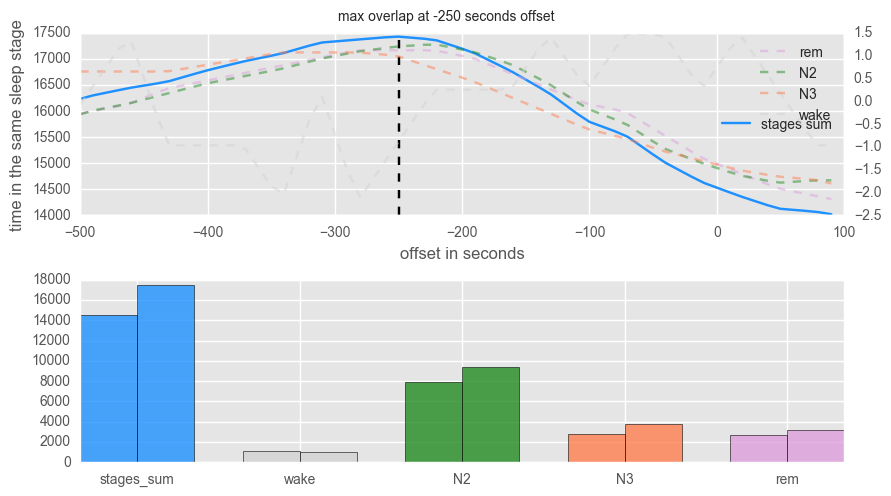

In [52]:
plot_intersection(intersection, shift_range)

hipnogram analysis indicates the same direction of time delay - psg is 4 minutes 10 seconds before neuroon. The time delay is larger for the hipnograms than for the signals by 1 minute 30 seconds.

Todo: 

* add second axis with percentages
* see if the overlap increased in proportion with offset
* add different correlation tests notebook
* add spectral and pca analysis

